# Crawl Data Analysis: Clustering

This notebook tries various clustering techniques on our web crawl data. It was written for Python 2.7, and assumes it's running on cycles. You can view/edit the notebook remotely as follows:

- Clone the GitHub repo to cycles (e.g. spin.cs.princeton.edu)
- Start up this notebook. Jupyter is not installed globally, but you can install it locally with pip via `pip install --user jupyter`. Then you can run this notebook in a tmux session: `tmux`, then `cd [this directory]`, then `jupyter notebook --no-browser --port 8889` (note that you can choose whatever port number you want, but we'll assume from here on it's 8889). Copy the URL generated - this is the URL you'll visit in your browser to open the notebook. Then Ctrl-B, D to detach the tmux session, and log out of cycles.
- On your local machine, forward your local port 8889 to the remote port 8889 on cycles: `ssh -L 8889:localhost:8889 [netid]@spin.cs.princeton.edu`
- Now you can open the notebook in your browser by pasting the link you copied earlier.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os

## Read from database

Read the crawl data from the database. Here we read in the `site_visits` and `segments` tables and join them.

In [2]:
import sqlite3
import pandas as pd

db = '/n/fs/darkpatterns/crawl/2018-12-08_segmentation_pilot2/2018-12-08_segmentation_pilot2.sqlite'
con = sqlite3.connect(db)
site_visits = pd.read_sql_query('''SELECT * from site_visits''', con)

/usr/lib64/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/lib64/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/lib64/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/lib64/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/lib64/python2.7/site-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility

In [3]:
print('Number of site visits: %s' % str(site_visits.shape))
print('site_visits columns: %s' % str(list(site_visits.columns.values)))

Number of site visits: (2839, 3)
site_visits columns: ['visit_id', 'crawl_id', 'site_url']


Report how many unique domains we have.

In [4]:
from urlparse import urlparse

site_visits['domain'] = site_visits['site_url'].apply(lambda x: urlparse(x).netloc)
grouped = site_visits.groupby(['domain']).count().sort_values('visit_id', ascending=False)

In [5]:
print('Number of unique domains: %s' % str(grouped.shape[0]))

Number of unique domains: 630


In [6]:
segments = pd.read_sql_query('''SELECT * from segments''', con)

In [7]:
print('Number of segments: %s' % str(segments.shape))
print('segments columns: %s' % str(list(segments.columns.values)))

Number of segments: (1124037, 22)
segments columns: ['id', 'crawl_id', 'visit_id', 'node_name', 'node_id', 'top', 'left', 'width', 'height', 'style', 'inner_text', 'outer_html', 'longest_text', 'longest_text_width', 'longest_text_height', 'longest_text_top', 'longest_text_left', 'longest_text_style', 'num_buttons', 'num_imgs', 'num_anchors', 'time_stamp']


In [8]:
segments = segments.reset_index().set_index('visit_id').join(site_visits.reset_index()[['visit_id', 'site_url', 'domain']].set_index('visit_id'), how='inner')

## Preprocess data

Ignore `body` tags and null `inner_text`, and add columns for number of newlines and length of `inner_text`.

In [9]:
segments['inner_text'] = segments['inner_text'].str.strip()
segments = segments[(segments['node_name'] != 'BODY') & (segments['inner_text'] != '')]
segments['newline_count'] = segments['inner_text'].apply(lambda x: len(x.split('\n')))
segments['inner_text_length'] = segments['inner_text'].apply(lambda x: len(x))

In [10]:
print('segments[\'newline_count\'].describe(): \n %s' % segments['newline_count'].describe().to_string())
print('segments[\'inner_text_length\'].describe(): \n %s' % segments['inner_text_length'].describe().to_string())

segments['newline_count'].describe(): 
 count    740532.000000
mean          3.981557
std          55.266438
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        5002.000000
segments['inner_text_length'].describe(): 
 count    740532.000000
mean        108.879522
std        3206.474593
min           1.000000
25%           5.000000
50%          14.000000
75%          35.000000
max      391699.000000


Replace numbers with a placeholder.

In [11]:
segments['inner_text_processed'] = segments['inner_text'].str.replace(r'\d+', 'DPNUM')
segments['longest_text_processed']= segments['longest_text'].str.replace(r'\d+', 'DPNUM')

Remove redundant segments.

In [12]:
segments = segments.groupby(['domain']).apply(lambda x: x.drop_duplicates(subset=['inner_text_processed'], keep='last'))

In [13]:
print('Number of segments: %s' % str(segments.shape))
print('segments columns: %s' % str(list(segments.columns.values)))

Number of segments: (75516, 28)
segments columns: ['index', 'id', 'crawl_id', 'node_name', 'node_id', 'top', 'left', 'width', 'height', 'style', 'inner_text', 'outer_html', 'longest_text', 'longest_text_width', 'longest_text_height', 'longest_text_top', 'longest_text_left', 'longest_text_style', 'num_buttons', 'num_imgs', 'num_anchors', 'time_stamp', 'site_url', 'domain', 'newline_count', 'inner_text_length', 'inner_text_processed', 'longest_text_processed']


## Create feature vectors

First we define the a function to tokenize text as we convert text into feature vectors. 

In [17]:
from nltk.stem.porter import PorterStemmer
import nltk

nltk.download('stopwords')

stemmer = PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

def tokenize(line):
    if (line is None):
        line = ''
    tokens = [stemmer.stem(t) for t in nltk.word_tokenize(line) if len(t) != 0 and t not in stopwords and not t.isdigit()]
    return tokens

Now select one of the following cells to run to create a feature representation. Either load from the pre-existing file or recompute the features.

### 1. Bag of words

In [18]:
if os.path.isfile('features_bow.npy'):
    features = np.load('features_bow.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

data = segments['inner_text_processed']
vec = CountVectorizer(tokenizer=tokenize, binary=binary_rep, strip_accents='ascii').fit(data)

In [20]:
print('Length of vocabulary %s' % str(len(vec.vocabulary_)))

In [21]:
vec = vec.transform(data)
features = normalize(vec, axis=0)
np.save('features_bow.npy', features)

### 2. TFIDF

In [22]:
if os.path.isfile('features_tfidf.npy'):
    features = np.load('features_tfidf.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
data = segments['inner_text_processed']
vec = TfidfVectorizer(tokenizer=tokenize, binary=False, strip_accents='ascii').fit(data)
features = vec.transform(data)
np.save('features_tfidf.npy', features)

In [24]:
print('Length of vocabulary %s' % str(len(vec.vocabulary_)))
print('features shape (num_examples, num_features): %s' % str(features.shape))

### 3. Word Vectors

We compute a vector for each segment as follows: compute the word vector for each word in the segment's `inner_text`, and then average over all words in that segment.

While it's simple, there are clearly downsides to this approach:

- We lose information about word ordering
- All words are equally weighted, so words that really characterize the text are not prioritized

In [14]:
if os.path.isfile('features_wordvec.npy'):
    features = np.load('features_wordvec.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')
    import en_core_web_sm

    data = segments['inner_text_processed']
    nlp = en_core_web_sm.load()
    vecs = []
    for doc in nlp.pipe(data.str.replace(r'\d+', '').astype('unicode').values, batch_size=10000, n_threads=7):
        if doc.is_parsed:
            vecs.append(doc.vector)
        else:
            vecs.append(None)
    features = np.array(vecs)
    np.save('features_wordvec.npy', features)
    
print('features shape: %s' % str(features.shape))

Loaded from file
features shape: (75516, 128)


### PCA
Try using PCA to reduce the dimension of the data.

The feature matrix is expected to be provided with examples in rows (`num_examples` x `num_features`).

Projected data is given by $U^T X$, where $U$ is matrix with PCs in columns (`orig_dim` x `reduced_dim`), and $X$ is the data matrix with examples in columns (`orig_dim` x `num_examples`). In our case, $U^T$ is `pca.components_` and $X$ is `features.T`.

In [15]:
if os.path.isfile('features_proj.npy'):
    features = np.load('features_proj.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')
    from sklearn.decomposition import PCA

    # DEBUGGING: Take a subset of the features before doing pca, for speed
#     features_orig = np.copy(features)
#     indices = np.random.choice(np.arange(features.shape[0]), size=1000, replace=False)
#     features = features[indices,:]
    
    pca = PCA(n_components=5)
    # pca = PCA(tol=10)
    pca.fit(features)
    
    print('Matrix of PCs: %s' % str(pca.components_.shape))
    print('Data matrix: %s' % str(features.shape))
    print('%d singular values: %s' % (pca.singular_values_.shape[0], str(pca.singular_values_)))
    
    features = np.dot(pca.components_, features.T)
    features = features.T
    
    np.save('features_proj.npy', features)
    
print('feature matrix shape (after PCA): %s' % str(features.shape))

Loaded from file
feature matrix shape (after PCA): (75516, 5)


Plot the data in the reduced dimension (assuming new dimension is 3, otherwise this is meaningless).

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features[:,0], features[:,1], features[:,2])

## Clustering

Run one of the following clustering algorithms.

### 1. Hierarchical clustering

In [23]:
from scipy.spatial import distance
import fastcluster

# featdense = features.todense()
distances = distance.pdist(features, metric='cosine')
distances = distance.squareform(distances, checks=False)

In [ ]:
clusters = fastcluster.linkage(distances, method='ward', preserve_input=False)
np.save('hierarchical_linkage_matrix.npy', clusters)

Plot a dendogram of the resulting clusters.

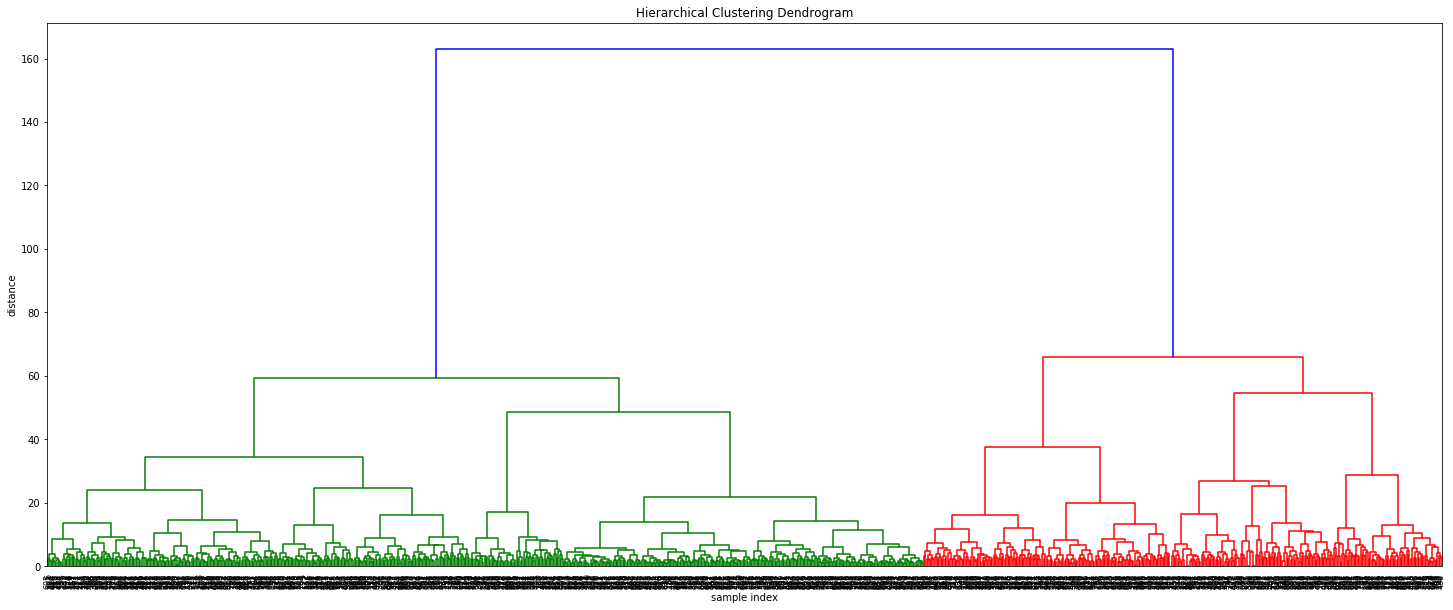

In [151]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    clusters,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

### 2. DBSCAN clustering

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.externals.joblib.parallel import parallel_backend

with parallel_backend('threading'):
    clusterer = DBSCAN(eps=0.0005, min_samples=3, n_jobs=10, metric='cosine')
    cluster_labels = clusterer.fit(features)

/usr/lib64/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/usr/lib64/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/usr/lib64/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/usr/lib64/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, depth_first_order, \
/usr/lib64/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:169: RuntimeWarning: numpy

In [17]:
segments['cluster'] = pd.Series(cluster_labels.labels_).values

In [18]:
print('segments[\'cluster\'].value_counts(): \n %s' % segments['cluster'].value_counts().to_string())

segments['cluster'].value_counts(): 
 -1       47221
 0        9264
 38        297
 3         263
 29        170
 160       122
 162       112
 10         80
 11         79
 278        74
 138        72
 76         66
 132        62
 277        60
 50         60
 9          56
 521        50
 204        50
 127        48
 359        48
 60         45
 39         44
 172        43
 61         43
 1049       43
 508        42
 137        42
 44         41
 33         41
 729        41
 85         41
 349        40
 125        40
 394        39
 337        39
 1          39
 79         39
 176        39
 111        38
 571        38
 653        38
 192        38
 468        37
 65         37
 19         37
 1230       37
 62         36
 32         36
 161        36
 249        35
 418        34
 807        34
 81         33
 480        32
 598        32
 308        31
 363        31
 105        31
 310        31
 437        31
 202        30
 758        30
 681        30
 490        30
 1

### 3. HDBSCAN clustering

In [97]:
from sklearn.preprocessing import normalize
import hdbscan

features = normalize(features, axis=1) # Normalize each segment since using euclidean distance metric
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
cluster_labels = clusterer.fit_predict(features)
segments['cluster'] = pd.Series(cluster_labels).values

In [98]:
print('segments[\'cluster\'].value_counts(): \n %s' % segments['cluster'].value_counts().to_string())

## Visualize results

Produce a CSV file that shows the segments in each cluster.

In [27]:
inner_texts = segments['inner_text']
cluster_labels = segments['cluster']
urls = segments['site_url']
print("segments['inner_text'] is %s, segments['cluster'] is %s, segments['site_url'] is %s (should be the same)" % (str(inner_texts.shape), str(cluster_labels.shape), str(urls.shape)))

segments['inner_text'] is (75516,), segments['cluster'] is (75516,), segments['site_url'] is (75516,) (should be the same)


Group the segments by cluster.

In [32]:
from collections import defaultdict

inner_text_by_cluster = defaultdict(lambda: [])
url_by_cluster = defaultdict(lambda: [])
for i in range(inner_texts.shape[0]):
    inner_text_by_cluster[str(cluster_labels[i])].append(inner_texts[i])
    url_by_cluster[str(cluster_labels[i])].append(urls[i])

Write CSV file.

In [33]:
import unicodecsv as csv
from datetime import datetime

timestamp = '_'.join(str(datetime.now()).split(' '))
outfile = 'clusters-%s.csv' % timestamp
with open(outfile, 'wb') as f:
    writer = csv.writer(f)
    for cluster in inner_text_by_cluster.keys():
        segments_str = '\n\n'.join(inner_text_by_cluster[cluster])
        writer.writerow([cluster, segments_str, url_by_cluster[cluster]])